In [1]:
import geopandas as gpd
import shapely.geometry as Point
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [ ]:
# API helper - Current Police API has a rate limit of 15 requests per second with a burst of 30
def get_api_response(url, retries = 5, backoff=1):
    for i in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"You have exceeded the rate limit. Waiting {backoff} seconds...")
            time.sleep(backoff)
            backoff *= 2
        else:
            print(f"Error {response.status_code} - {response.text}")
            return None
    return None

In [ ]:
# List of Bristol area outcodes (first half of postcode)
outcodes = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BS8', 'BS9', 'BS10', 'BS11', 'BS13', 'BS14', 'BS15', 'BS16', 'BS30', 'BS34']

def fetch_postcodes_from_outcodes(outcodes):
    all_postcodes = []

    for outcode in outcodes:
        url = f"https://api.postcodes.io/outcodes/{outcode}"
        result = get_api_response(url)

        if not result or not result.get('result'):
            continue

        lat = result['result']['latitude']
        lng = result['result']['longitude']

        # Fetch postcodes in this area
        postcodes_response = get_api_response(f"https://api.postcodes.io/postcodes?lon={lng}&lat={lat}&radius=3000")
        data = postcodes_response.get('result', [])

        if not data:
            return []
        
        all_postcodes.extend([p['postcode'] for p in data])
        time.sleep(1)

    return list(set(all_postcodes))

In [ ]:
def get_lat_lng(postcode):
    url = f"https://api.postcodes.io/postcodes/{postcode}"
    result = get_api_response(url)
    if result and result.get('result'):
        return result['result']['latitude'], result['result']['longitude']
    return None, None

In [ ]:
# Get data for past N months
def generate_months(n):
    base = datetime.today().replace(day=1)
    return [(base - relativedelta(months=i)).strftime("%Y-%m") for i in range(n)]

In [ ]:
def fetch_crime_data(postcodes, months):
    all_crimes = []
    lat_lng_cache = {}

    for postcode in postcodes:
        lat, lng = lat_lng_cache.get(postcode, (None, None))
        if not lat:
            lat, lng = get_lat_lng(postcode)
            lat_lng_cache[postcode] = (lat, lng)
        if not lat:
            print(f"Couldn't get location for {postcode}, skipping.")
            continue

        for month in months:
            url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={lng}&date={month}"
            print(f"Fetching crimes for {postcode} ({month})")
            crimes = get_api_response(url)
            if crimes:
                for crime in crimes:
                    crime['postcode'] = postcode
                    crime['month'] = month
                all_crimes.extend(crimes)
            time.sleep(0.2)  # Rate limit protection

    return all_crimes

In [ ]:
postcodes = fetch_postcodes_from_outcodes(outcodes)
months = generate_months(15) # Sometimes police API is not upto date
crime_data = fetch_crime_data(postcodes, months)


In [ ]:
# Save to file
df = pd.DataFrame(crime_data)
df.to_csv("../data/filton_crime_data.csv", index=False)
print("Crime data saved to ../data/filton_crime_data.csv")
df.head()

In [ ]:
df.dtypes

In [2]:
# Load CSV instead of refetching data for a quick runtime
df = pd.read_csv("../data/filton_crime_data.csv")
df.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.509414', 'street': {'id': 228...",NaN,NaN,NaN,126955191,NaN,2025-03,BS34 6QB
1,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",NaN,NaN,NaN,126954994,NaN,2025-03,BS34 6QB
2,anti-social-behaviour,Force,"{'latitude': '51.536107', 'street': {'id': 227...",NaN,NaN,NaN,126954920,NaN,2025-03,BS34 6QB
3,anti-social-behaviour,Force,"{'latitude': '51.536292', 'street': {'id': 228...",NaN,NaN,NaN,126954911,NaN,2025-03,BS34 6QB
4,anti-social-behaviour,Force,"{'latitude': '51.529787', 'street': {'id': 227...",NaN,NaN,NaN,126955952,NaN,2025-03,BS34 6QB


In [ ]:
df.dtypes

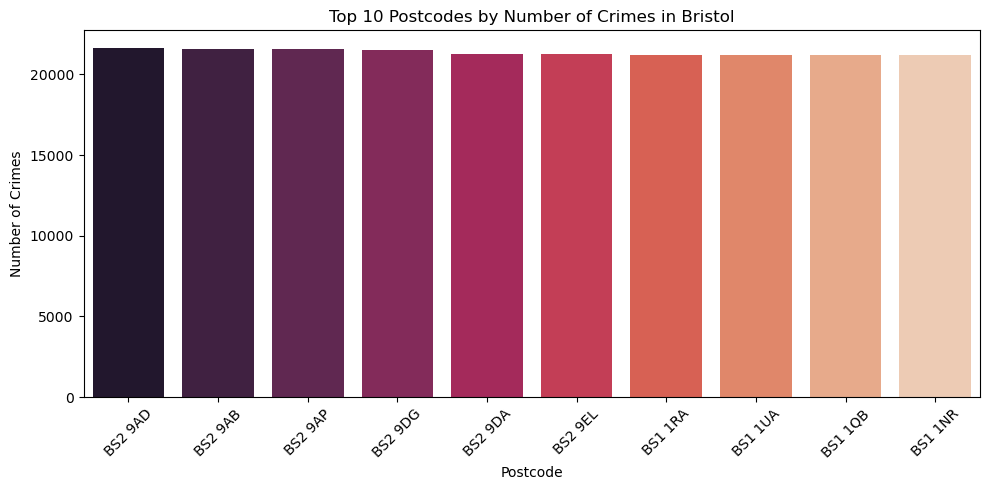

In [4]:
# Top 10 postcodes with most crime
top_postcodes = df['postcode'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=top_postcodes.values, palette="rocket")
plt.title('Top 10 Postcodes by Number of Crimes in Bristol')
plt.xlabel('Postcode')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

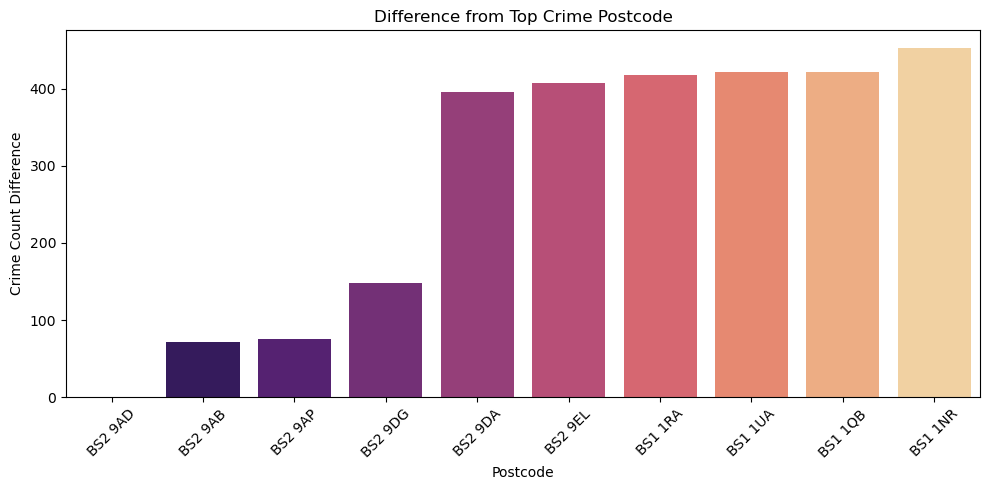

In [5]:
top_value = top_postcodes.values[0]
differences = top_value - top_postcodes.values

plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=differences, palette="magma")
plt.title('Difference from Top Crime Postcode')
plt.ylabel('Crime Count Difference')
plt.xlabel('Postcode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

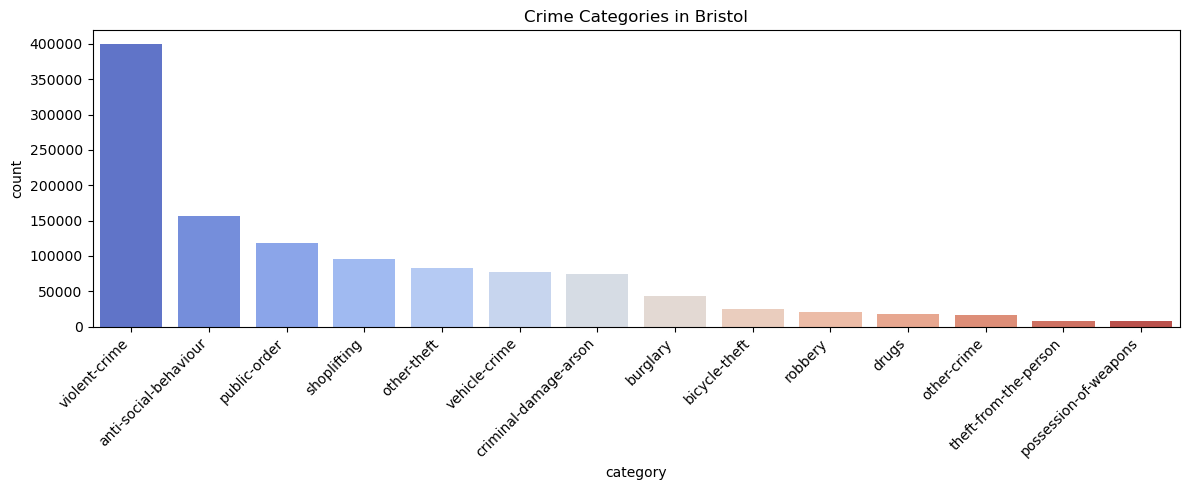

In [6]:
# Crime category vs Number of Crimes
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette="coolwarm")
plt.title('Crime Categories in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


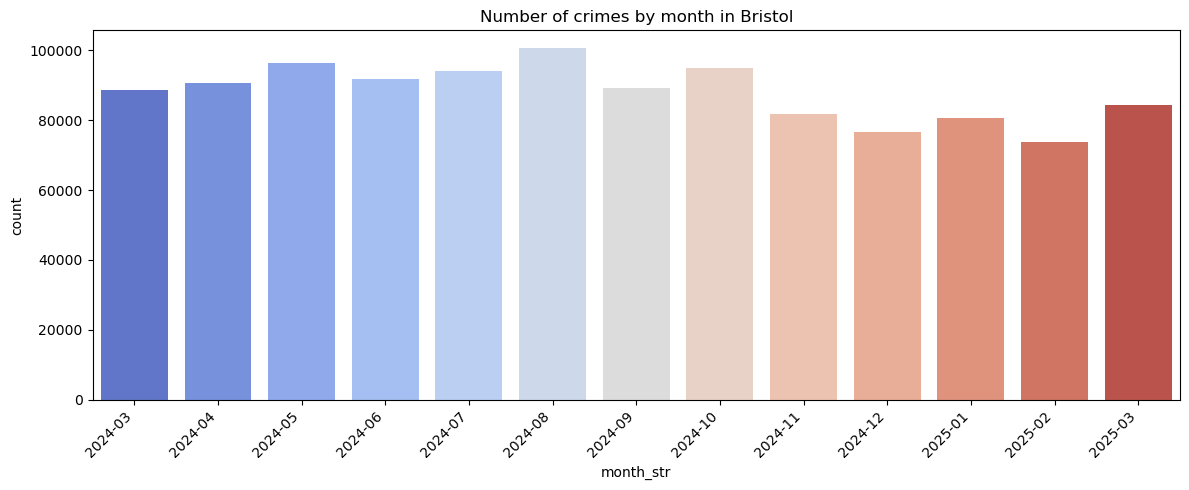

In [7]:
# Crimes by month
df['month'] = pd.to_datetime(df['month'])

# Extract year-month as string for plotting
df['month_str'] = df['month'].dt.strftime('%Y-%m')

# Sort months
sorted_months = df['month'].sort_values().dt.strftime('%Y-%m').unique()

# Plot
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='month_str', order=sorted_months, palette="coolwarm")
plt.title('Number of crimes by month in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Create map centred on Filton
crime_map = folium.Map(location=[51.454514, -2.587910], zoom_start=14)

import ast

# Convert 'location' column from string to dict if necessary
if isinstance(df['location'].iloc[0], str):
	df['location'] = df['location'].apply(ast.literal_eval)

# Filter out missing data
df = df[df['location'].notnull() & df['location'].apply(lambda loc: loc.get('latitude') and loc.get('longitude'))]

df['lat'] = df['location'].apply(lambda loc: float(loc['latitude']))
df['lng'] = df['location'].apply(lambda loc: float(loc['longitude']))

heat_data = df[['lat', 'lng']].values.tolist()

# Add heat effect to the map
HeatMap(heat_data, radius=15, blur=25, max_zoom=15).add_to(crime_map)

# Save map as HTML
crime_map.save("../assets/filton_crime_map.html")
print("Crime heatmap saved as filton_crime_map.html. Open it in a browser!")

Crime heatmap saved as filton_crime_map.html. Open it in a browser!


In [9]:
# Get all column names
df.columns

Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'postcode',
       'month_str', 'lat', 'lng'],
      dtype='object')

In [10]:
# Shape
df.shape

(1143585, 13)

In [11]:
# Replace empty strings with NaN for uniformity
df_cleaned = df.replace('', np.nan)

# Total number of rows with missing values
df_cleaned.isna().sum()

category                  0
location_type             0
location                  0
context             1143585
outcome_status       156432
persistent_id        160480
id                        0
location_subtype    1139537
month                     0
postcode                  0
month_str                 0
lat                       0
lng                       0
dtype: int64

In [12]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=['outcome_status', 'context', 'persistent_id', 'location_subtype', 'location_type', 'month_str', 'location'], axis=1)
df_cleaned.head()

,category,id,month,postcode,lat,lng
0,anti-social-behaviour,126955191,2025-03-01,BS34 6QB,51.509414,-2.571967
1,anti-social-behaviour,126954994,2025-03-01,BS34 6QB,51.513031,-2.571378
2,anti-social-behaviour,126954920,2025-03-01,BS34 6QB,51.536107,-2.576238
3,anti-social-behaviour,126954911,2025-03-01,BS34 6QB,51.536292,-2.567748
4,anti-social-behaviour,126955952,2025-03-01,BS34 6QB,51.529787,-2.586869


In [13]:
# Regex pattern for YYYY-MM format
pattern = r'^\d{4}-(0[1-9]|1[0-2])$'

# Convert month to string in YYYY-MM format and check validity
month_str = df_cleaned['month'].dt.strftime('%Y-%m')
invalid_count = (~month_str.str.match(pattern)).sum()
print(f"Number of invalid dates: {invalid_count}")

Number of invalid dates: 0


In [14]:
# Seperate Year and Month to different columns
# df_cleaned[["year", "month"]] = df["month"].str.split("-", expand = True)
# df_cleaned.head()

In [15]:
# Count crime categories
crime_category_count = df_cleaned['category'].value_counts()
print(crime_category_count)

violent-crime            399132
anti-social-behaviour    156432
public-order             118242
shoplifting               96454
other-theft               82404
vehicle-crime             77397
criminal-damage-arson     73857
burglary                  43328
bicycle-theft             24596
robbery                   21245
drugs                     18592
other-crime               16177
theft-from-the-person      8063
possession-of-weapons      7666
Name: category, dtype: int64


In [16]:
# Recategorised crimes to imporve generalisation
crime_category_map = {
    'violent-crime': 'violence',
    'robbery': 'violence',
    'shoplifting': 'theft',
    'burglary': 'theft',
    'vehicle-crime': 'theft',
    'bicycle-theft': 'theft',
    'theft-from-the-person': 'theft',
    'other-theft': 'theft',
    'anti-social-behaviour': 'anti-social',
    'public-order': 'anti-social',
    'criminal-damage-arson': 'anti-social',
    'drugs': 'drugs',
    'possession-of-weapons': 'other', 
    'other-crime': 'other'
}

df_cleaned['recategorised_crimes'] = df_cleaned['category'].map(crime_category_map)

# Assign any unmapped crimes to 'other' category
df_cleaned['recategorised_crimes'] = df_cleaned['recategorised_crimes'].fillna('other')

crime_category_count = df_cleaned['recategorised_crimes'].value_counts()
print(crime_category_count)

violence       420377
anti-social    348531
theft          332242
other           23843
drugs           18592
Name: recategorised_crimes, dtype: int64


In [17]:
df_cleaned.head()

,category,id,month,postcode,lat,lng,recategorised_crimes
0,anti-social-behaviour,126955191,2025-03-01,BS34 6QB,51.509414,-2.571967,anti-social
1,anti-social-behaviour,126954994,2025-03-01,BS34 6QB,51.513031,-2.571378,anti-social
2,anti-social-behaviour,126954920,2025-03-01,BS34 6QB,51.536107,-2.576238,anti-social
3,anti-social-behaviour,126954911,2025-03-01,BS34 6QB,51.536292,-2.567748,anti-social
4,anti-social-behaviour,126955952,2025-03-01,BS34 6QB,51.529787,-2.586869,anti-social


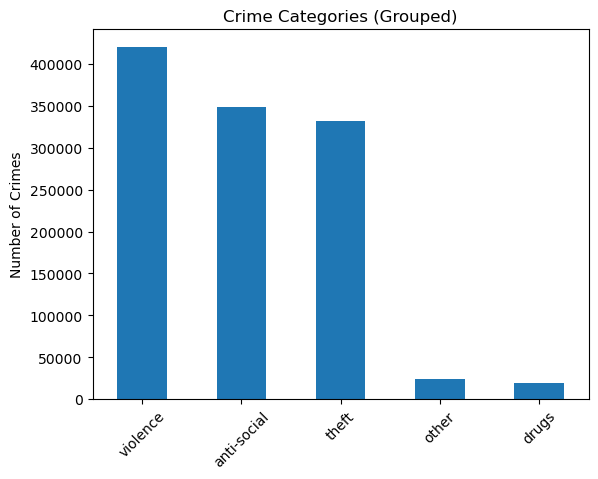

In [18]:
df_cleaned['recategorised_crimes'].value_counts().plot(kind='bar')
plt.title("Crime Categories (Grouped)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

In [19]:
# Total crimes per postcode
total_crimes_per_postcode = df_cleaned.groupby('postcode').size().reset_index(name='total_crimes')
print(total_crimes_per_postcode)

    postcode  total_crimes
0    BS1 1BU         21156
1    BS1 1DL         21108
2    BS1 1NR         21188
3    BS1 1PN         21180
4    BS1 1QB         21219
..       ...           ...
165  BS9 3RS          2273
166  BS9 3RT          2266
167  BS9 3SB          2336
168  BS9 3SZ          2370
169  BS9 3UA          2336

[170 rows x 2 columns]


In [20]:
# Crimes per postcode per month
monthly_crime = (
    df_cleaned.groupby(['postcode', 'month'])
    .size()
    .reset_index(name='monthly_crimes')
)

monthly_crime.sort_values(['postcode', 'month'])

print(monthly_crime)

     postcode      month  monthly_crimes
0     BS1 1BU 2024-03-01            1649
1     BS1 1BU 2024-04-01            1720
2     BS1 1BU 2024-05-01            1813
3     BS1 1BU 2024-06-01            1666
4     BS1 1BU 2024-07-01            1728
...       ...        ...             ...
2205  BS9 3UA 2024-11-01             162
2206  BS9 3UA 2024-12-01             174
2207  BS9 3UA 2025-01-01             142
2208  BS9 3UA 2025-02-01             136
2209  BS9 3UA 2025-03-01             164

[2210 rows x 3 columns]


In [21]:
# Add lag features
monthly_crime['lag_1'] = monthly_crime.groupby('postcode')['monthly_crimes'].shift(1)
monthly_crime['lag_3'] = monthly_crime.groupby('postcode')['monthly_crimes'].shift(1).rolling(3).mean().reset_index(0, drop=True)


In [22]:
monthly_crime['month_num'] = monthly_crime['month'].dt.month # Get month

In [23]:
# Get unique postcodes
postcode_location = df_cleaned[['postcode', 'lat', 'lng']].drop_duplicates(subset='postcode')

In [24]:
# Drop empty rows
df_features = monthly_crime.dropna(subset=['lag_1', 'lag_3'])

In [25]:
# Check time range
print(df_cleaned['month'].min(), df_cleaned['month'].max())

2024-03-01 00:00:00 2025-03-01 00:00:00


In [26]:
# Split by time
train = df_features[df_features['month'] <= '2025-01-01']
test = df_features[df_features['month'] >= '2025-02-01']
future = df_features[df_features['month'] == '2025-04-01']  

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (1360, 6)
Test size: (340, 6)


In [27]:
# To predict crimes for the future month

features = ['month_num', 'lag_1', 'lag_3']
X_train = train[features]
y_train = train['monthly_crimes']

X_test = test[features]
y_test = test['monthly_crimes']

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))


MSE: 5228.529296875
R² score: 0.9674021601676941


In [28]:
# Get March data (for April lag features)
march = monthly_crime[monthly_crime['month'] == '2025-03-01'].copy()

# Calculate lag features for April
march['month'] = pd.to_datetime('2025-04-01')
march['lag_1'] = march['monthly_crimes']
march['lag_3'] = march.groupby('postcode')['monthly_crimes'].rolling(3).mean().reset_index(0, drop=True)

# Update month_num
march['month_num'] = march['month'].dt.month

# Drop 'crime_count' — we want to predict it
X_future = march[features]
march['predicted_crime_count'] = model.predict(X_future)

future_data = march[['postcode', 'month', 'predicted_crime_count']]
# Merge location info
future_data = future_data.merge(postcode_location, on='postcode', how='left')

print(future_data)


    postcode      month  predicted_crime_count        lat       lng
0    BS1 1BU 2025-04-01            1683.478149  51.464278 -2.584387
1    BS1 1DL 2025-04-01            1683.478149  51.464683 -2.586018
2    BS1 1NR 2025-04-01            1715.983398  51.452961 -2.596173
3    BS1 1PN 2025-04-01            1715.983398  51.456703 -2.585081
4    BS1 1QB 2025-04-01            1683.478149  51.456677 -2.592162
..       ...        ...                    ...        ...       ...
165  BS9 3RS 2025-04-01            1211.459595  51.482899 -2.649429
166  BS9 3RT 2025-04-01            1216.801270  51.482899 -2.649429
167  BS9 3SB 2025-04-01            1209.634033  51.500933 -2.636921
168  BS9 3SZ 2025-04-01            1213.122925  51.473569 -2.630637
169  BS9 3UA 2025-04-01            1221.306274  51.490334 -2.641498

[170 rows x 5 columns]


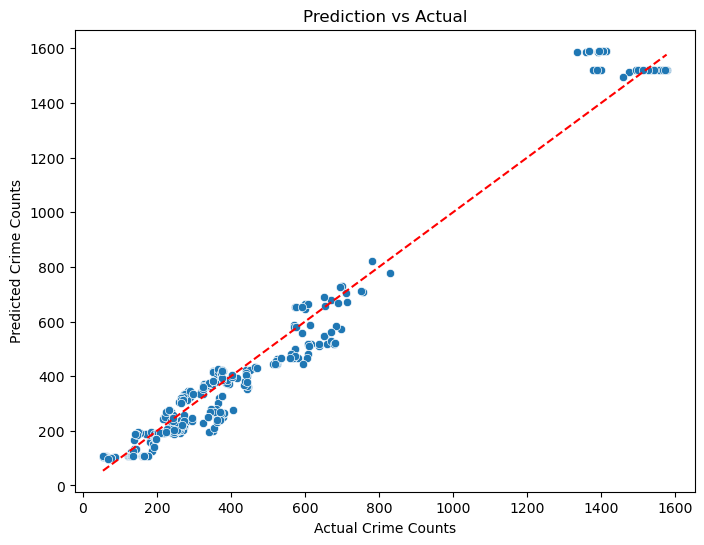

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Crime Counts")
plt.ylabel("Predicted Crime Counts")
plt.title("Prediction vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()


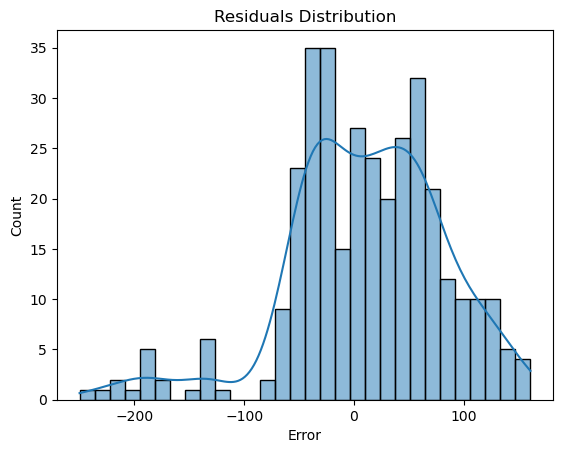

In [30]:
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.show()


In [31]:
# Save model
joblib.dump(model, 'xgb_model.pkl')

# Save future predictions
future_data.to_csv('../data/future_predictions.csv', index=False)

In [51]:
# Classify Likely Type of Crime in a Postcode

common_crime_category_per_postcode_month = (
   df_cleaned.groupby(['postcode', 'month'])['recategorised_crimes']
   .agg(lambda x: x.value_counts().idxmax())
   .reset_index(name='top_crime')
)

crime_count_per_month = df_cleaned.groupby(['postcode', 'month']).size().reset_index(name='crime_count_per_month')

df_classify = common_crime_category_per_postcode_month.merge(crime_count_per_month, on=['postcode', 'month'])
df_classify = df_classify.merge(df_cleaned[['postcode', 'lat', 'lng']].drop_duplicates(), on='postcode', how='left')
df_classify['month_num'] = pd.to_datetime(df_classify['month']).dt.month


In [52]:
df_classify['top_crime'].value_counts(normalize=True)

violence       0.705203
theft          0.173233
anti-social    0.121564
Name: top_crime, dtype: float64

In [53]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_classify['label'] = le.fit_transform(df_classify['top_crime'])

In [54]:
features = ['month_num', 'crime_count_per_month']
X = df_classify[features]
y = df_classify['label']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

clf = XGBClassifier()
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

 anti-social       0.84      0.99      0.91     21836
       theft       0.71      0.97      0.82     31118
    violence       0.99      0.87      0.93    126675

    accuracy                           0.91    179629
   macro avg       0.85      0.95      0.89    179629
weighted avg       0.93      0.91      0.91    179629



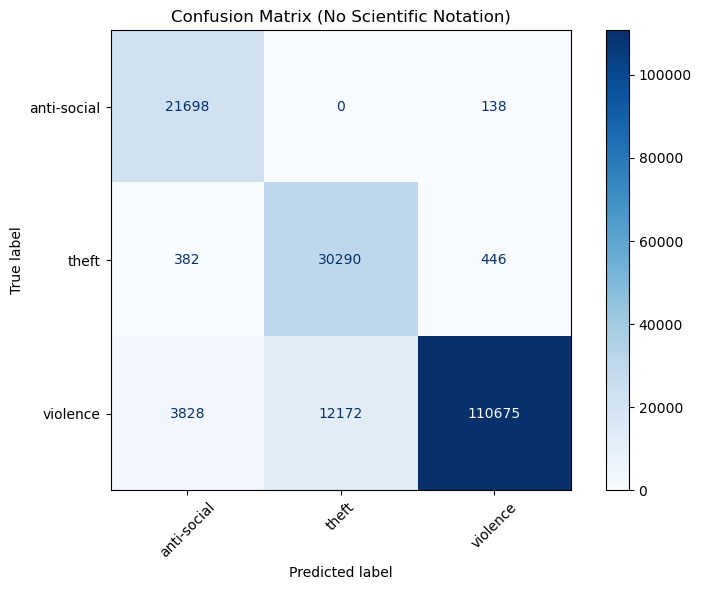

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d') 
plt.title("Confusion Matrix (No Scientific Notation)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
X_all = df_classify[['month_num', 'crime_count_per_month']]
y_all_proba = clf.predict_proba(X_all)

proba_df = pd.DataFrame(y_all_proba, columns=le.inverse_transform(np.arange(y_all_proba.shape[1])))

output_df = pd.concat([df_classify[['postcode', 'lat', 'lng', 'month_num', 'crime_count_per_month']], proba_df], axis=1)
output_df.head()

,postcode,lat,lng,month_num,crime_count_per_month,anti-social,theft,violence
0,BS1 1BU,51.464278,-2.584387,3,1649,0.000123,0.995551,0.004326
1,BS1 1BU,51.452961,-2.596173,3,1649,0.000123,0.995551,0.004326
2,BS1 1BU,51.450979,-2.598608,3,1649,0.000123,0.995551,0.004326
3,BS1 1BU,51.456137,-2.590414,3,1649,0.000123,0.995551,0.004326
4,BS1 1BU,51.451227,-2.588681,3,1649,0.000123,0.995551,0.004326


In [58]:
output_df.to_csv('../data/top_crimes_per_postcode.csv', index=False)

In [43]:
joblib.dump(clf, 'xgb_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']